# Proyecto 3 - Minería de datos
***Universidad del Valle de Guatemala***

___4 de marzo, 2025___

[link del reposiotio](https://github.com/DanielRasho/MD-Proyecto3)

**Autores:**
- Daniel Alfredo Rayo Roldán
- Gerardo Pineda
- Juan Luis

# Introducción
De acuerdo a *Herre, Samborska & Roser* (2025) varios medios parecen indicar que la cantidad de divorcios que ocurre cada año ha estado creciendo con los años, de hecho, según el Registro Nacional de Personas en Guatemala (2024) la cantidad de matrimonios disminuyeron y los divorcios aumentaron en 2024. Sin embargo se falla en realizar estos datos a nivel historico y entre diferentes países, dado que las variaciones son muy marcadas entre diferentes países, habiendo países cuya tasa de divorcios ha disminuido versus, otros que siguen en aument como paises bajos (Herre, Samborska & Rose, 2025). Este proyecto sera un intento en poder predecir que parejas se divorcian y las tendencias historicas en Guatemala.

# Situación Problemática

Durante la última década (2013–2023), se ha evidenciado una tendencia creciente en el número de divorcios registrados en Guatemala. Esta alza, especialmente notoria tras la disminución temporal en 2020 atribuida a la pandemia, ha generado inquietudes sobre los factores que impulsan la disolución de los matrimonios.

Diversos elementos sociodemográficos como la edad de los cónyuges, su nivel educativo, y las ocupaciones que desempeñan, parecen jugar un papel relevante en esta problemática. En particular, se ha observado que los matrimonios entre personas jóvenes podrían estar enfrentando mayores tasas de separación, lo cual sugiere una transformación en las dinámicas familiares y sociales del país.

Frente a esta realidad, se vuelve urgente estudiar estos patrones con un enfoque predictivo, de manera que se puedan anticipar tendencias futuras en el número de divorcios.

## Objetivos Generales

Usando los datos del INE (Instituto nacional de Guatemala) entre 2013 a 2020 sobre divorcios y matrimonios en Guatemala, se plantea: 

- Entrener un modelo que pueda predecir que parejas son propensas a divorciarse.
- Predecir la cantidad de divorcios futuros para los próximos 5 años.

## Objetivos Específicos
1. Determinar si el comportamiento de divorcios es creciente o decreciente.
2. Determinar cual fue el comportamiento de la cantidad de divorcios antes, durante y después de pandemia.
3. Predecir las carácteristicas socioeconómicas que tendrán los divorcios en los próximos 5 años.

In [1318]:
import warnings
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score
from scipy.stats import shapiro, kstest
from sklearn.decomposition import PCA
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Dont print warnings
warnings.simplefilter(action="ignore")

# Descripción de los datos
Se partieron de 2 sets de datos proporcionados por el INE (Instituto Nacional de Estadística) sobre matrimonios y divorcios ocurridos en Guatemala entre los años 2013 hasta 2023 (11 años) ambos contando con las mismas 19 variables. El set de divorcios comprende 76669 registros, la totalidad de los datos registrados por el INE. El set matrimonios comprende 76670, el cual es una muestra del set total, para tener un cantidad balanceada a los divorcios. **Se asumió que los todas las parejas en el conjunto de matrimonios se mantuvieron casadas durante el rango de tiempo estudiado,** es decir no hay parejas registradas en ambos datasets de matrimonios y divorcios.

Se necesitó hacer un procesamiento de los datos, dado que las disposición y nombre de las variables cambió ligeramente a lo largo de los años, diferencias que se unificaron en las siguientes variables finales, con las que se trabajó:

**Variables númericas:**

| Descripcion | Codificación | Categoría Nula |
|-----------------|-------|----|
| Edad del hombre | EDADHOM  | 999 |
| Edad de la mujer | EDADMUJ | 999 |

**Variables categóricas:**

| Descripcion | Codificación | Categoría Nula | 
|-----------------------------------|-------|---|
| Departamento de registro          | DEPREG | N/A |
| Municipio de registro             | MUPREG   |N/A | 
| Mes de registro                   | MESREG   |N/A |
| Año de registro                   | AÑOREG   |N/A |
| Día de ocurrencia                 | DIAOCU |N/A |
| Mes de ocurrencia                 | MESOCU  |N/A |
| Año de ocurrencia                 | AÑOOCU |N/A |
| Departamento de ocurrencia        | DEPOCU |N/A |
| Municipio de ocurrencia           |  MUPOCU |N/A |
| Grupo étnico del hombre           | PUEHOM | 9 |
| Grupo étnico de la mujer          | PUEMUJ | 9 |
| Nacionalidad del hombre           | NACHOM | 9999 | 
| Nacionalidad de la mujer          | NACMUJ | 9999 |
| Escolaridad del hombre            | ESCHOM | 9 | 
| Escolaridad de la mujer           | ESCMUJ | 9 |
| Ocupación del hombre              | CIUOHOM | 99 | 
| Ocupación de la mujer             | CIUOMUJ | 99 |

***Nota:*** *La "categoría nula" para las variables en las que aplica, indica ese valor reservado para observaciones "sin definir"; se podrían considerar como un equivalente del Nan.*


In [ ]:
# Step 1: Get all CSV file paths
divorces_files = glob.glob("data/divorces/*.CSV")
marriage_files = glob.glob("data/marriages/*.csv")

# Step 2: Define a generator to read and process each file on the fly
def read_and_clean(file):
    df = pd.read_csv(file)
    return df

numerical_var = ["EDADHOM", "EDADMUJ"]
categorical_var = [
    "DEPREG",
    "MUPREG",
    "MESREG",
    "AÑOREG",
    "DIAOCU",
    "MESOCU",
    "AÑOOCU",
    "DEPOCU",
    "MUPOCU",
    "PUEHOM", 
    "PUEMUJ", 
    "NACHOM", 
    "NACMUJ", 
    "ESCHOM", 
    "ESCMUJ", 
    "CIUOMUJ", 
    "CIUOHOM"]

# Step 3: Merge without storing copies
divorces_df = pd.concat((read_and_clean(file) for file in divorces_files), ignore_index=True)
marriages_df = pd.concat((read_and_clean(file) for file in marriage_files), ignore_index=True)
divorces_df["ARE_MARRIAGED"] = 0
marriages_df["ARE_MARRIAGED"] = 1
total_df = pd.concat([divorces_df, marriages_df], ignore_index=True)
divorces_df.drop(columns="ARE_MARRIAGED", inplace=True)
marriages_df.drop(columns="ARE_MARRIAGED", inplace=True)

In [1320]:
# Now dictionary mappings are defined in extern script. Call the variables just as usual
%run ./dictionaries.py

## Análisis de variables
Con la base de datos preparada, se procedio a inspeccionar las características y frencuencias de las diferentes variables con el fin de determinar si algunas podrian ser descartadas o simplificadas debido a la poca información que ofrecen.

Sin embargo, es primero importante describir la distribución de datos nulos en cada uno de las variables: 

**Datos nulos para datos de divorcios**

In [1321]:
df_null_values = divorces_df[["EDADHOM", "EDADMUJ", "PUEHOM", "PUEMUJ", "NACHOM", "NACMUJ", "ESCHOM", "ESCMUJ", "CIUOMUJ", "CIUOHOM"]]
null_values = {
    "EDADHOM": 999,
    "EDADMUJ": 999,
    "PUEHOM": 9,
    "PUEMUJ": 9,
    "NACHOM": 9999,
    "NACMUJ": 9999,
    "ESCHOM": 9,
    "ESCMUJ": 9,
    "CIUOMUJ": 99,
    "CIUOHOM": 99
}

# function to count null-like values
def count_nulls(df, column, null_value):
    # Count how many times the null_value appears in the column
    return (df[column] == null_value).sum()

null_counts = {col: count_nulls(divorces_df, col, null_vals) for col, null_vals in null_values.items()}

null_counts_df = pd.DataFrame(list(null_counts.items()), columns=["Variable", "Frecuencia de valores nulos"])
total_rows = len(divorces_df)
null_counts_df["% de valores nulos"] = (null_counts_df["Frecuencia de valores nulos"] / total_rows) * 100
null_counts_df["% de valores nulos"] = null_counts_df["% de valores nulos"].round(1)

null_counts_df

,Variable,Frecuencia de valores nulos,% de valores nulos
0,EDADHOM,34573,45.1
1,EDADMUJ,34521,45.0
2,PUEHOM,37606,49.0
3,PUEMUJ,37726,49.2
4,NACHOM,298,0.4
5,NACMUJ,306,0.4
6,ESCHOM,33234,43.3
7,ESCMUJ,32856,42.9
8,CIUOMUJ,23712,30.9
9,CIUOHOM,19831,25.9


**Datos nulos para datos de matrimonios**

In [1322]:
df_null_values = marriages_df[["EDADHOM", "EDADMUJ", "PUEHOM", "PUEMUJ", "NACHOM", "NACMUJ", "ESCHOM", "ESCMUJ", "CIUOMUJ", "CIUOHOM"]]

# function to count null-like values
def count_nulls(df, column, null_value):
    # Count how many times the null_value appears in the column
    return (df[column] == null_value).sum()

null_counts = {col: count_nulls(marriages_df, col, null_vals) for col, null_vals in null_values.items()}

null_counts_df = pd.DataFrame(list(null_counts.items()), columns=["Variable", "Frecuencia de valores nulos"])
total_rows = len(marriages_df)
null_counts_df["% de valores nulos"] = (null_counts_df["Frecuencia de valores nulos"] / total_rows) * 100
null_counts_df["% de valores nulos"] = null_counts_df["% de valores nulos"].round(1)

null_counts_df

,Variable,Frecuencia de valores nulos,% de valores nulos
0,EDADHOM,13,0.0
1,EDADMUJ,18,0.0
2,PUEHOM,5012,6.5
3,PUEMUJ,7076,9.2
4,NACHOM,0,0.0
5,NACMUJ,2,0.0
6,ESCHOM,2907,3.8
7,ESCMUJ,4767,6.2
8,CIUOMUJ,1143,1.5
9,CIUOHOM,742,1.0


Se puede observar que en todas las variables donde hay posibilidad de haber datos nulos, hay un porcentaje considerable, siendo en los menores las variables de *Nacionalidad*, y las mayores las variables de *Grupo étnico*. Para el tratamiento de dichas se hicieron los siguientes pasos:

**Datos nulos**

Para los datos nulos, viendo que tomaban un espacio considerable del dataset se descartó la idea de remplazarlo por los datos más populares del dataset, o el descartar las filas que los contuvieran. La siguiente opción fue crear un modelo que prediciera cuales podrían ser los valores nulos en base a los patrones que exciben las demás variables, sin embargo para ello fue primero necesario determinar que hubiera algún tipo de correlación entre las variables, para ello se elaboró la matriz de correlación siguiente.

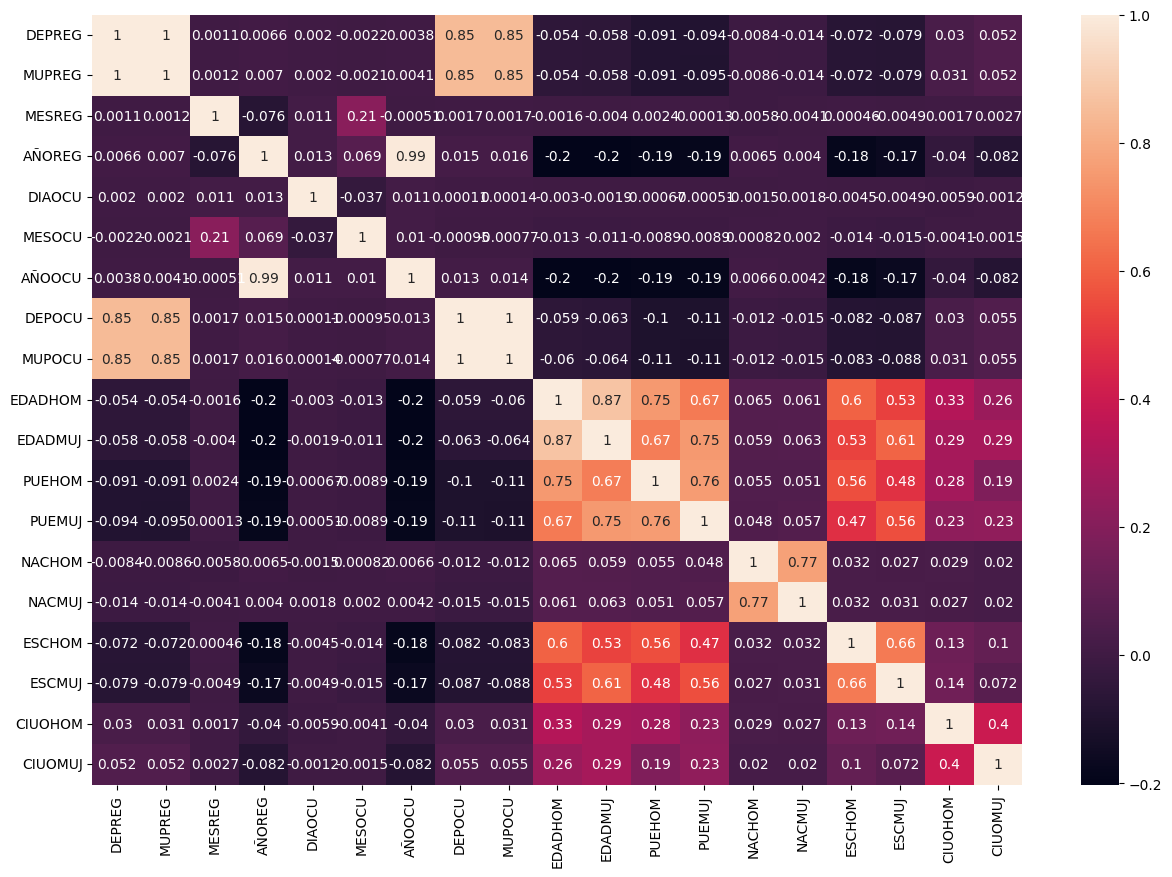

In [1323]:
# 2. 
corr = divorces_df.corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns, annot=True, )
%matplotlib inline

In [1324]:
# 2. 
corr = marriages_df.corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns, annot=True, )
%matplotlib inline

ValueError: could not convert string to float: 'Guatemala'